In [329]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn
import optax

In [331]:
time_delay_dim = 10
time_delay = 10
time_range = (0, 600, 0.02)
n_centers = 500

In [334]:
# n_points = len(np.arange(*time_range))
# constant_current_duration = 2500
# n_current_plateaus = n_points//constant_current_duration
# np.random.seed(21)
# random_i = np.random.uniform(-15, 60, size=(n_current_plateaus, 1))
# stimulus_list = (np.ones((n_current_plateaus, constant_current_duration))*random_i).reshape((-1, ))
# stimulus = lib.custom_stimulus(stimulus_list=stimulus_list, time_range=time_range, time_constant=10)

# stimulus = lib.lorenz1996_stimulus(N=8, F=6, time_range=time_range, initial_state=[1, 2, 8.01, 4, 8, 5], time_constant=10, rescale_factor=2.)
# stimulus.get_stimulus_list()

stimulus = lib.lorenz1963_stimulus(time_range=(0, 600, 0.02), )
stimulus.get_stimulus_list()
# tmp1 = stimulus.stimulus_list
# tmp2 = np.ones(30000)*0
# tmp2[:3000] = 15
# tmp2[3000:4000] = 0
# tmp2[4000:7000] = 12
# tmp2[7000:8000] = -2
# tmp2[8000:11000] = 9
# tmp2[11000:14000] = 5
# tmp2[14000:15000] = 10
# tmp2[15000:16000] = -5
# tmp2[16000:19000] = 13
# tmp2[19000:20000] = -10
# tmp2[20000:22000] = 0
# tmp2[22000:26000] = 11
# tmp2[26000:27000] = 3
# tmp2[27000:28000] = -8
# tmp2[28000:29000] = 7

# tmp = np.concatenate((tmp1, tmp2))
# stimulus = lib.custom_stimulus(tmp, time_range=time_range)


# stimulus = lib.constant_stimulus(dc_stimulus=15, time_range=time_range)
# stimulus.get_stimulus_list()

training_neuron = lib.single_neuron_odeint(stimulus, [0, 0, 0, 0])
training_neuron.generate_sol()

In [335]:
drop_first_n_points = 5000
training_neuron.sol = training_neuron.sol[drop_first_n_points:]
stimulus.stimulus_list = stimulus.stimulus_list[drop_first_n_points:]

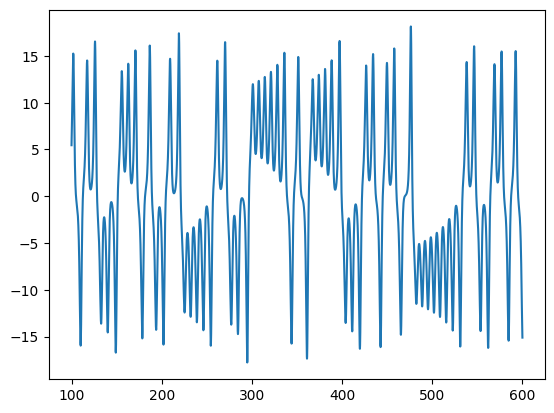

In [336]:
plt.plot(np.arange(*time_range)[drop_first_n_points:], stimulus.stimulus_list)

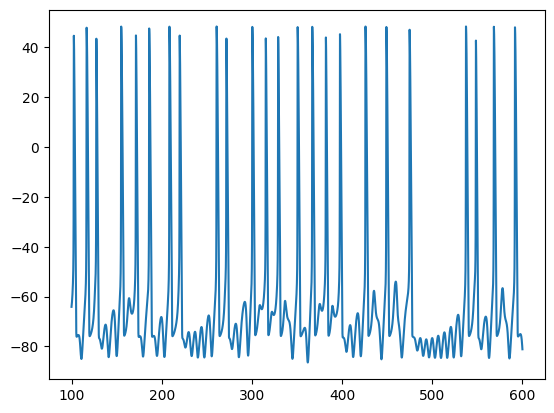

In [337]:
plt.plot(np.arange(*time_range)[drop_first_n_points:], training_neuron.sol[:, 0])

In [338]:
# get points in time delay coordinate and k-means centers
points_time_delay = np.array([np.roll(training_neuron.sol[:, 0], -i*time_delay) for i in range(time_delay_dim)]).T
points_time_delay = points_time_delay[: -time_delay*(time_delay_dim-1)]
kmeans = KMeans(n_clusters=n_centers, random_state=0, n_init="auto").fit(points_time_delay)

In [339]:
# search for sigma
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=8, algorithm="ball_tree").fit(kmeans.cluster_centers_)
distances, _ = nbrs.kneighbors(kmeans.cluster_centers_)
sigma = distances[:, -1]

In [340]:
# training by doing linear/ridge regression
class train_by_regression():
    def __init__(self, centers, voltage_list, current_list, time_delay, time_delay_dim, time_spacing, beta, R, membrane_capacitance=1) -> None:
        self.centers = centers # (n_centers, time_delay_dim)
        self.voltage_list = voltage_list
        self.current_list = current_list
        self.time_delay = time_delay
        self.time_delay_dim = time_delay_dim
        self.time_spacing = time_spacing
        self.beta = beta
        self.R = R # R = 1/sigma^2
        self.membrane_capacitance = membrane_capacitance
        self.X = None
        self.Y = None

        self._pre_processing()

    def _pre_processing(self):
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training is the time_delay*(time_delay_dim-1)^th point.
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-1-first_usable_t_idx, :]

        def get_distances_to_centers(x):
            diff = self.centers - x
            dist = jnp.exp(-np.sum(diff**2, axis=-1)*self.R/2)
            return dist

        self.X = jax.vmap(get_distances_to_centers, in_axes=0)(tmp_v)
           
        tmp_delta_v = self.voltage_list[first_usable_t_idx+1:] - self.voltage_list[first_usable_t_idx:-1]
        tmp_i = (self.current_list + jnp.roll(self.current_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1]
        self.Y = tmp_delta_v/self.time_spacing - tmp_i/self.membrane_capacitance

    def get_weights(self):
        ridge = sklearn.linear_model.Ridge(alpha=self.beta, fit_intercept=False)
        self.ridge = ridge.fit(self.X, self.Y)
        self.score = ridge.score(self.X, self.Y)
        return ridge.coef_
    
class rbf_model_plus_ann(nn.Module):
    time_delay_dim: int
    R: Union[Sequence[float], float]
    centers: Sequence[float]
    weights: Sequence[float]

    def setup(self) -> None:
        self.layer1 = nn.Dense(features=10)
        self.layer11 = nn.Dense(features=10)
        self.layer2 = nn.Dense(features=1, kernel_init=jax.nn.initializers.zeros, bias_init=jax.nn.initializers.zeros)
        self.layer3 = nn.Dense(features=20)
        # self.layer4 = nn.Dense(features=10)
        self.layer5 = nn.Dense(features=1)

        self.activation_last = lambda x: nn.activation.sigmoid(x) - jnp.log(2)

    def __call__(self, x):
        x = jnp.atleast_2d(x)
        return jax.vmap(self.single_evaluation, in_axes=0)(x)

    def single_evaluation(self, x):
        x_i = x[self.time_delay_dim:]
        x_v = x[:self.time_delay_dim]
        diff = (self.centers - x_v)**2
        diff = jnp.sum(diff, axis=-1)*self.R/2
        dist = jnp.exp(-diff)
        y = dist@self.weights

        z = jnp.concatenate((dist, x_i))
        z = self.layer1(z)
        z = nn.activation.softplus(z)
        z = self.layer11(z)
        z = nn.activation.softplus(z)
        z = self.layer2(z)
        g = self.layer3(dist)
        # g = nn.activation.softplus(g)
        # g = self.layer4(g)
        g = nn.activation.softplus(g)
        g = self.layer5(g)
        # g = nn.activation.softplus(g)

        return jnp.array([y]) + z*g
    

In [341]:
"""RBF part training by regression"""
R = 1/sigma**2
beta = 0.01
RBF_train = train_by_regression(kmeans.cluster_centers_, training_neuron.sol[:, 0], stimulus.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R)
w = RBF_train.get_weights()
rbf1 = rbf_model_plus_ann(time_delay_dim=time_delay_dim, R=R, centers=jnp.array(kmeans.cluster_centers_), weights=w)
pred_model = lib.prediction_model_with_current(rbf1, time_spacing=time_range[-1])
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros((time_delay_dim)), jnp.zeros((time_delay_dim))) # this is useless, but have to be here to take the place of some functions' arguments
params0 = params

In [342]:
RBF_train.score

0.996121843295994

In [343]:
class train_with_current():
    def __init__(self, 
        stimulus_list: Sequence[float], # 1d array
        voltage_list: Sequence[float], # 1d array
        model: lib.prediction_model_with_current,
        time_delay: int,
        time_delay_dim: int,
        time_range: Sequence[int], #(start, end, spacing)
        batch_size: int):

        self.stimulus_list = stimulus_list
        self.voltage_list = voltage_list
        self.model = model
        self.time_delay, self.time_delay_dim = time_delay, time_delay_dim
        self.time_range = time_range
        self.batch_size = batch_size
        self.n_batches = None
        self.batches = None 
        # the shape of batches is (n_batches, batch_size, time_delay_dim + 2)
        # the last dimension of batches is (V(t-n*tau), V(t-(n-1)*tau), ..., V(t-tau), V(t))
        self.loss_list = None

    def get_batches(self, key):
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training is the time_delay*(time_delay_dim-1)^th point.
        n_points = len(self.voltage_list) - first_usable_t_idx - 1 # -1 because the prediction always needs the data at the next time step
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-1-first_usable_t_idx, :]

        tmp_i = ((self.stimulus_list + jnp.roll(self.stimulus_list, -1))/2)[:-1]
        tmp_i = jnp.array([jnp.roll(tmp_i, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_i = tmp_i[:-first_usable_t_idx, :]

        tmp_pred_v = self.voltage_list[first_usable_t_idx+1:].reshape((-1, 1))

        tmp = jnp.concatenate((tmp_v, tmp_i, tmp_pred_v), axis=-1) # dim of tmp is (n_points, time_delay_dim+2)
        tmp = jax.random.permutation(key, tmp, axis=0, independent=False)
        self.n_batches = max(int(round(n_points/self.batch_size))-1, 1)
        self.batches = (tmp[:self.n_batches*self.batch_size, :]).reshape((self.n_batches, self.batch_size, 2*self.time_delay_dim+1))

In [344]:
"""ANN part training by BP"""
ANN_train = lib.train_with_current(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=24900)
# ANN_train = lib.train_with_current_multi_prediction(stimulus_list=stimulus.stimulus_list, voltage_list=training_neuron.sol[:, 0], model=pred_model, time_delay=time_delay, time_delay_dim=time_delay_dim, time_range=time_range, batch_size=6000, n_prediction_steps=10)
ANN_train.get_batches(jax.random.PRNGKey(0))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = ANN_train.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [04:08<00:00,  8.06it/s, loss=7.3898824e-05] 


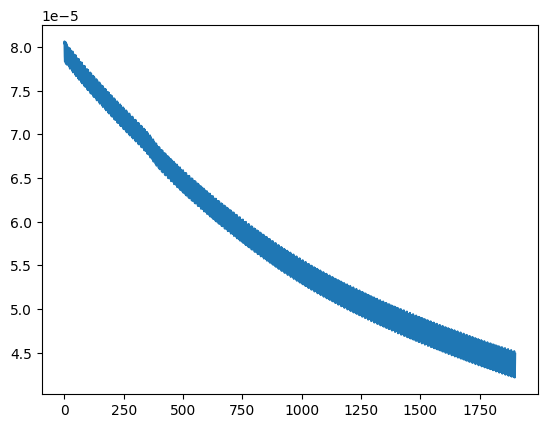

In [321]:
plt.plot(ANN_train.loss_list[100:])

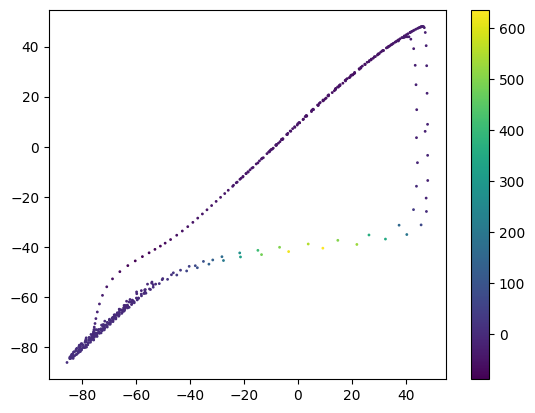

In [322]:
plot_start = 0 
plot_end = -1
def get_distances_to_centers(x):
    diff = kmeans.cluster_centers_ - x
    dist = jnp.exp(-np.sum(diff**2, axis=-1)*R/2)
    return dist
dist = jax.vmap(get_distances_to_centers, in_axes=0)(kmeans.cluster_centers_)

# plt.plot(points_time_delay[:, 1], points_time_delay[:, 0], linewidth=1)
plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=(dist@w)[plot_start:plot_end], s=1)
# plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=np.clip((dist@w)[plot_start:plot_end], a_min=-30, a_max=10), s=1)
plt.colorbar()
# plt.xlim(-85, -40)
# plt.ylim(-85, -40)

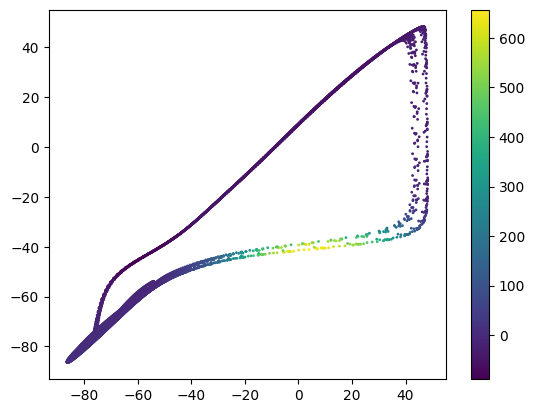

In [323]:
dist = jax.vmap(get_distances_to_centers, in_axes=0)(points_time_delay)
plt.scatter(points_time_delay[plot_start:plot_end, -1], points_time_delay[plot_start:plot_end, -2], c=(dist@w)[plot_start:plot_end], s=1)
# plt.scatter(kmeans.cluster_centers_[:, -1][plot_start:plot_end], kmeans.cluster_centers_[:, -2][plot_start:plot_end], c=np.clip((dist@w)[plot_start:plot_end], a_min=-30, a_max=10), s=1)
plt.colorbar()

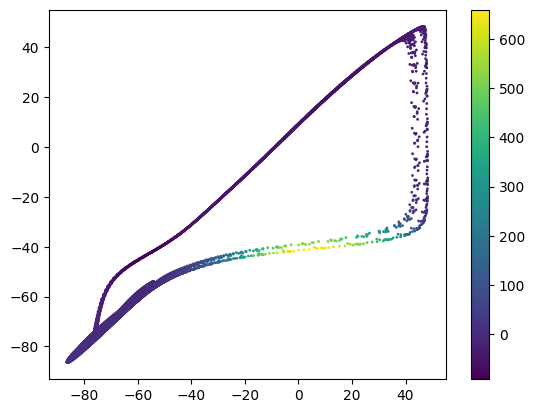

In [325]:
x = training_neuron.sol[time_delay:, 0]
y = training_neuron.sol[:-time_delay, 0]
dx = x[1:] - x[:-1]
dx[-1] = 0
i = stimulus.stimulus_list[time_delay:]
avg_i = (i[:-1]+i[1:])/2
dx = dx/time_range[2] - avg_i
plt.scatter(x[:-1], y[:-1], c=dx[:], s=1)
# plt.scatter(x[:-1], y[:-1], c=np.clip(dx[:], a_min=-25, a_max=20), s=1)
plt.colorbar()
# plt.xlim(-80, -60)
# plt.ylim(-80, -60)

In [357]:
"""prediction based on test neuron and stimulus"""

# stimulus_test = lib.lorenz1963_stimulus(time_range=time_range, )
stimulus_test = lib.constant_stimulus(dc_stimulus=10, time_range=time_range)
stimulus_test.get_stimulus_list()
test_neuron = lib.single_neuron_odeint(stimulus_test, [-10, 0, 0.8, 0.5])
test_neuron.generate_sol()

initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1200
initial_piece = test_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list = stimulus_test.stimulus_list[prediction_start_after+initial_piece_len:]
pred_run_test = lib.generate_prediction_with_current(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run_test.run(params, n_steps=2000)

100%|██████████| 2000/2000 [02:53<00:00, 11.54it/s]


In [358]:
"""prediction based on test neuron and stimulus (without ann)"""
pred_run_test0 = lib.generate_prediction_with_current(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run_test0.run(params0, n_steps=2000)

100%|██████████| 2000/2000 [02:59<00:00, 11.13it/s]


In [345]:
"""prediction based on training neuron and stimulus"""
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1200
initial_piece = training_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list = stimulus.stimulus_list[prediction_start_after+initial_piece_len:]
pred_run = lib.generate_prediction_with_current(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run.run(params, n_steps=20000)

100%|██████████| 20000/20000 [32:31<00:00, 10.25it/s]


In [351]:
"""prediction based on training neuron and stimulus (without ann)"""
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1200
initial_piece = training_neuron.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list = stimulus.stimulus_list[prediction_start_after+initial_piece_len:]
pred_run0 = lib.generate_prediction_with_current(pred_model, time_delay, time_delay_dim, stimulus_list, initial_piece)
pred_run0.run(params0, n_steps=20000)

100%|██████████| 20000/20000 [28:54<00:00, 11.53it/s]


Text(0, 0.5, 'current (nA)')

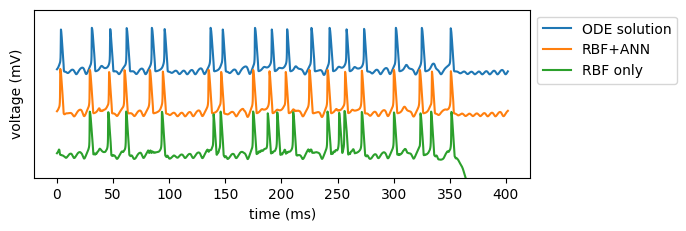

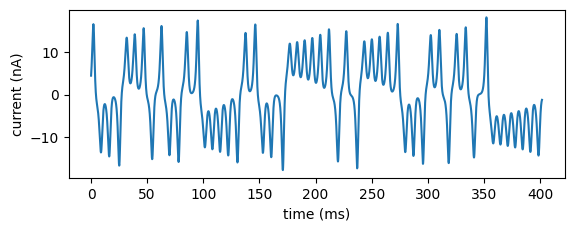

In [356]:
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 20000

plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(0, (end-start)*0.02, 0.02), training_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0], label="ODE solution")
plt.plot(np.arange(0, (end-start)*0.02, 0.02), pred_run.prediction_list[start:end]-120, label="RBF+ANN")
plt.yticks([])
plt.plot(np.arange(0, (end-start)*0.02, 0.02), pred_run0.prediction_list[start:end]-240, label="RBF only")
plt.ylim(-380, 100)
plt.xlabel("time (ms)")
plt.ylabel("voltage (mV)")
plt.legend(bbox_to_anchor=(1,1))
plt.figure(2)
plt.subplot(212)
plt.plot(np.arange(0, (end-start)*0.02, 0.02), training_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
plt.xlabel("time (ms)")
plt.ylabel("current (nA)")
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

ValueError: x and y must have same first dimension, but have shapes (25091,) and (24300,)

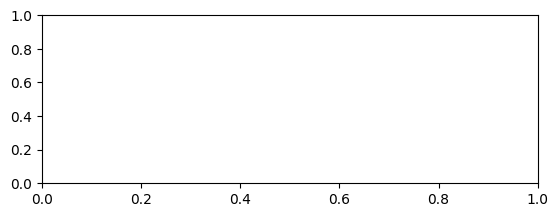

In [328]:
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 25000

plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(0, (end-start)*0.02, 0.02), training_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0]+100, label="ODE solution")
plt.plot(np.arange(0, (end-start)*0.02, 0.02), pred_run.prediction_list[start:end]-60, label="RBF+ANN")
plt.plot(np.arange(0, (end-start)*0.02, 0.02), pred_run0.prediction_list[start:end]-240, label="RBF only")
plt.yticks([])
plt.xlabel("time (ms)")
plt.ylabel("voltage")
plt.legend(bbox_to_anchor=(1,1))
plt.figure(2)
plt.subplot(212)
plt.plot(np.arange(0, (end-start)*0.02, 0.02), training_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
plt.xlabel("time (ms)")
plt.ylabel("current (nA)")
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

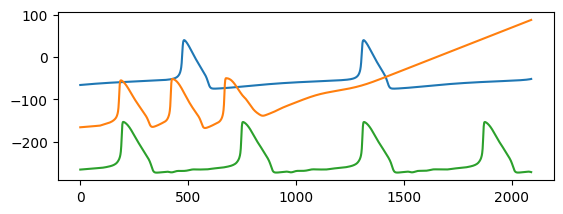

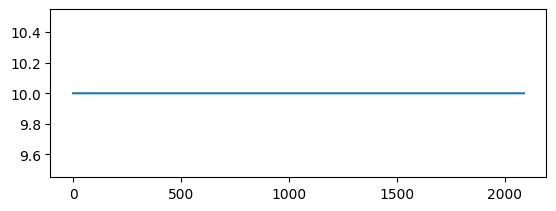

In [359]:
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 2000

plt.figure(1)
plt.subplot(211)
plt.plot(test_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0])
plt.plot(pred_run_test0.prediction_list[start:end]-100)
plt.plot(pred_run_test.prediction_list[start:end]-200)
plt.figure(2)
plt.subplot(212)
plt.plot(test_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

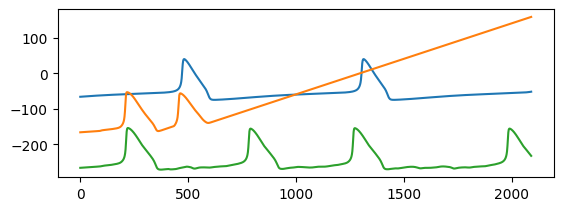

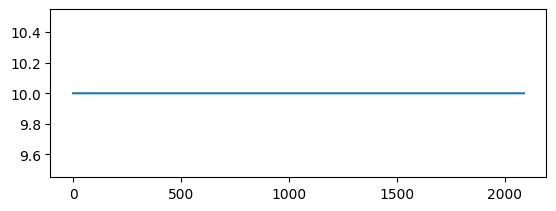

In [137]:
start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 2000

plt.figure(1)
plt.subplot(211)
plt.plot(test_neuron.sol[prediction_start_after+start: prediction_start_after+end, 0])
plt.plot(pred_run_test0.prediction_list[start:end]-100)
plt.plot(pred_run_test.prediction_list[start:end]-200)
plt.figure(2)
plt.subplot(212)
plt.plot(test_neuron.stimulus.stimulus_list[prediction_start_after+start: prediction_start_after+end])
# plt.plot(test_neuron.sol[start+prediction_start_after:end+prediction_start_after, 0])

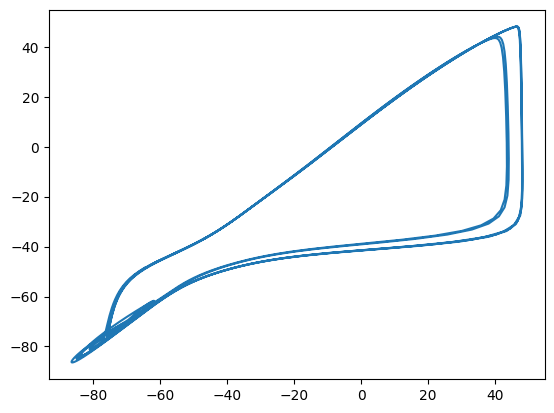

In [23]:
# plt.plot(pred_run.prediction_list[start+time_delay:end], pred_run.prediction_list[start:end-time_delay])
plt.plot(training_neuron.sol[prediction_start_after+start+time_delay: prediction_start_after+end, 0], training_neuron.sol[prediction_start_after+start: prediction_start_after+end-time_delay, 0])
# plt.scatter(kmeans.cluster_centers_[:, -1], kmeans.cluster_centers_[:, -2], s=1, c="red")